In [61]:
import pandas as pd 
import numpy as np
import sklearn.preprocessing

In [62]:
def handle_missing_actor_value (df, num_actors):
    for i in range (1, num_actors + 1):
        actor_pos = f'actor{i}_nconst'
        actor_null_mask = df[actor_pos].isna()
        actor_non_null_mask = ~actor_null_mask
        df.loc[actor_null_mask, actor_pos] = -1
        for suffix in ['_actor_sentiment', '_prior1_rating_actor', '_prior2_rating_actor', '_prior3_rating_actor', '_prior_movie_actor_sentiment']:
            col_name = f'actor{i}{suffix}'
            if col_name in df.columns:
                df.loc[actor_null_mask, col_name] = -1
                df.loc[actor_non_null_mask & df[col_name].isna(), col_name] = 0
    return df

In [63]:
def handle_missing_director_value (df):
    director_null_mask = df['directors'].isna()
    director_non_null_mask = ~director_null_mask
    df.loc[director_null_mask, 'directors'] = -1
    for col_name in ['prior_movie_director_sentiment', 'prior1_rating_director', 'prior2_rating_director', 'prior3_rating_director']:
        if col_name in df.columns:
            df.loc[director_null_mask, col_name] = -1
            df.loc[director_non_null_mask & df[col_name].isna(), col_name] = 0
    return df

In [64]:
def fill_mean (df, column, groupby):
    df[column] = df[column].fillna(df.groupby(groupby)[column].transform('mean'))
    return df

In [65]:
def categorize_runtime(df, column_name='runtime'):
    # Define bins (in minutes)
    bins = [0, 90, 120, 150, float('inf')]
    labels = ['short', 'medium', 'long', 'very_long']

    # Create a new column for runtime category
    df['runtime_category'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)

    return df

In [66]:
def one_hot_encode_columns(df, columns):
    for col in columns:
        encoder = sklearn.preprocessing.OneHotEncoder(sparse_output=False)
        encoded = encoder.fit_transform(df[[col]])
        # Preserve original index to avoid new rows being created
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=df.index)
        # Concatenate safely
        df = pd.concat([df.drop(col, axis=1), encoded_df], axis=1)

    return df


In [67]:
def remove_actors_columns(df, num_actors):
    for i in range (1, num_actors + 1):
        actor_id = f'actor{i}_nconst'
        actor_name = f'actor{i}_primaryName'
        actor_sentiment = f'actor{i}_actor_sentiment'
        df = df.drop(columns=[actor_id, actor_name, actor_sentiment])
    return df

In [68]:
def align_columns(df_train, df_test):
    for col in df_train.columns:
        if col not in df_test.columns:
            df_test[col] = 0
    df_test = df_test[df_train.columns]
    return df_test

# Split data

## Variables

In [ ]:
num_actors = 10
split_ratio = 0.8
columns_to_drop = ['Unnamed: 0', 'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'directors', 'category', 'job']
votes_max = 1000

In [113]:
useBackslash = True 
retrieveDatasetFrom = r'..\data\dataset_num_votes_log.csv' if useBackslash else r'../data/dataset_num_votes_log.csv'
data = pd.read_csv(retrieveDatasetFrom, sep=';')

In [114]:
data['directors'] = data['directors'].replace(r'\N', np.nan)

In [115]:
data = data.sort_values(by=['startYear', '_orig_order'])
data = data[np.expm1(data['movie_score']) > votes_max]
# Calculate the split index
split_index = int(len(data) * split_ratio)
# Determine the split year
split_year = data.iloc[split_index]['startYear']
# Split the dataframe
df_train = data.iloc[:split_index]
df_test = data.iloc[split_index:]

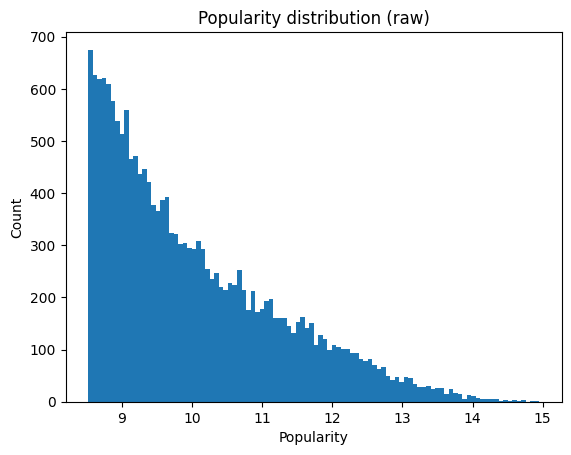

In [117]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure()
plt.hist(data['movie_score'], bins=100)
plt.title("Popularity distribution (raw)")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

# Preparing training set

### Handle missing values

In [95]:
df_train = handle_missing_director_value(df_train)

In [96]:
df_train = handle_missing_actor_value(df_train, num_actors)
df_train = fill_mean(df_train, 'runtimeMinutes', 'startYear')
df_train['runtimeMinutes'] = df_train['runtimeMinutes'].fillna(0)

C:\Users\ander\AppData\Local\Temp\ipykernel_15504\4222368349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df.groupby(groupby)[column].transform('mean'))
C:\Users\ander\AppData\Local\Temp\ipykernel_15504\978920888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['runtimeMinutes'] = df_train['runtimeMinutes'].fillna(0)


### One hot encode

In [97]:
df_train = categorize_runtime(df_train, 'runtimeMinutes')


C:\Users\ander\AppData\Local\Temp\ipykernel_15504\3191613727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['runtime_category'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)


In [98]:
df_train = one_hot_encode_columns(df_train, ['genre_1', 'genre_2', 'genre_3', 'runtime_category'])

In [99]:
df_train = df_train.sort_values(by=['startYear', '_orig_order'])

In [100]:
df_train = df_train.dropna(subset=['tconst'])

### Drop columns

In [101]:
df_train = remove_actors_columns(df_train, num_actors)
df_train = df_train.drop(columns=columns_to_drop)

In [103]:
saveTrainingDatasetAt = r'..\data\training_dataset_num_votes_log_1000.csv' if useBackslash else r'../data/training_dataset_num_votes_log_1000.csv'
df_train.to_csv(saveTrainingDatasetAt, sep =';')

# Preparing test set

### Handle missing values

In [104]:
df_test = handle_missing_director_value(df_test)
df_test = handle_missing_actor_value(df_test, num_actors)
df_test = fill_mean(df_test, 'runtimeMinutes', 'startYear')

C:\Users\ander\AppData\Local\Temp\ipykernel_15504\4222368349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df.groupby(groupby)[column].transform('mean'))


### One hot encode

In [105]:
df_test = categorize_runtime(df_test, 'runtimeMinutes')
df_test = one_hot_encode_columns(df_test, ['genre_1', 'genre_2', 'genre_3', 'runtime_category'])

C:\Users\ander\AppData\Local\Temp\ipykernel_15504\3191613727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['runtime_category'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)


In [106]:
df_test = df_test.dropna(subset=['tconst'])

### Drop columns

In [107]:
df_test = remove_actors_columns(df_test, num_actors)
df_test = df_test.drop(columns=columns_to_drop)

In [108]:
df_test = align_columns(df_train, df_test)

In [109]:
saveTestDatasetAt = r'..\data\test_dataset_num_votes_log_over_1000.csv' if useBackslash else r'../data/test_dataset_num_votes_log_over_1000.csv'
df_test.to_csv(saveTestDatasetAt, sep =';')